# (1) Data collection using both, Web Scraping and a Web API.

### Overpass turbo query to get all available electronc stores in Switzerland

In [22]:
#Libaries
import os
import re
import time
import fnmatch
import numpy as np
import pandas as pd
from pandas import json_normalize
import requests
import json
!pip install overpy
import overpy
import matplotlib.pyplot as plt
import folium

# Ignore warnings
import warnings
warnings.filterwarnings("ignore")

In [18]:
# Overpass API URL
url = "http://overpass-api.de/api/interpreter"

# Overpass turbo query

query = f"""[out:json][timeout:25];
        area["ISO3166-1"="CH"][admin_level=2];
        (node["shop"="electronics"](area);
          way["shop"="electronics"](area);
          relation["shop"="electronics"](area);
        );
        out body;
        >;
        out skel qt;"""


# Web API request
r = requests.get(url, params={'data': query})
data = r.json()['elements']


# Save data to file
with open('amazon_laptops.json', 'w') as json_file:
    json.dump(data, json_file)

# Store data in data frame
df = json_normalize(data)
df.head(10)

,type,id,lat,lon,tags.addr:city,tags.addr:housenumber,tags.addr:postcode,tags.addr:street,tags.alt_name,tags.branch,...,tags.electronics_repair,tags.man_made,tags.product,tags.toilets,tags.payment:contactless,tags.mobile,tags.operator:website,tags.currency:XBT,tags.payment:lightning,tags.payment:onchain
0,node,264793364,47.415612,8.621313,Dietlikon,7,8305,Neue Winterthurerstrasse,Media Markt Dietlikon,Dietlikon,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,node,289891415,47.420855,8.394058,Dietikon,5,8953,Riedstrasse,Media Markt Dietikon,Dietikon,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,node,301222858,47.372669,8.526643,Zürich,20,8004,Birmensdorferstrasse,Fust Center Eschenmoser,Zürich Birmensdorferstrasse,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,node,301222947,47.377878,8.525860,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,node,305000498,47.374132,8.524447,Zürich,109,8004,Badenerstrasse,Fust Badenerstrasse,Zürich Badenerstrasse,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,node,308058574,47.390682,8.514957,Zürich,60b,8005,Pfingstweidstrasse,Digitec Zürich,Zürich,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,node,366036773,46.688747,7.678992,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,node,409815800,47.067264,7.599899,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,node,411760524,47.497027,8.715051,Winterthur,42,8400,Zürcherstrasse,Digitec Winterthur,Winterthur,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,node,415256810,46.007794,8.952331,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


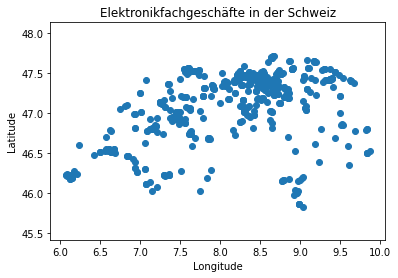

In [20]:
# Mit Python auf Overpass-API zugreifen, indem man das overpy-Paket als "Wrapper" verwendet
api = overpy.Overpass()
r = api.query("""
        area["ISO3166-1"="CH"][admin_level=2];
        (node["shop"="electronics"](area);
        way["shop"="electronics"](area);
        relation["shop"="electronics"](area););
        out center; 
        """)
# Die Anweisung "out center" erstellt Mittelpunktskoordinaten unter dem Schlüssel center; 
# wenn Knotenelement, dann sind Koordinaten unter den Schlüsseln Iat und Ion zu finden
coords  = []
coords += [(float(node.lon), float(node.lat)) 
           for node in r.nodes]
coords += [(float(way.center_lon), float(way.center_lat)) 
           for way in r.ways]
coords += [(float(rel.center_lon), float(rel.center_lat)) 
           for rel in r.relations]

    
# Koordinaten in ein numpy array konvertieren
X = np.array(coords)
plt.plot(X[:, 0], X[:, 1], 'o')
plt.title('Elektronikfachgeschäfte in der Schweiz')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.axis('equal')
plt.show()

In [21]:
# Subset of electronic stores by brand
locations = df[["lat", "lon", "tags.brand", "tags.shop"]].loc[(df["tags.brand"] == 'Interdiscount') | 
                                                              (df["tags.brand"] == 'Fust') |
                                                              (df["tags.brand"] == 'melectronics') |
                                                              (df["tags.brand"] == 'Media Markt ') |
                                                               (df["tags.brand"] == 'Digitec') 
                                                              
                                                             ] 
print(locations.head(20))

# Create map
map = folium.Map(location=[locations.lat.mean(), 
                           locations.lon.mean()], 
                 zoom_start=8, 
                 control_scale=True)

# Add maker symbols
for index, location_info in locations.iterrows():
    folium.Marker([location_info["lat"], 
                   location_info["lon"]], 
                  popup=location_info["tags.brand"]).add_to(map)

# Plot map
map

          lat       lon     tags.brand    tags.shop
6   46.688747  7.678992  Interdiscount  electronics
9   46.007794  8.952331  Interdiscount  electronics
23  47.537726  7.730229           Fust  electronics
26  46.522168  6.628902  Interdiscount  electronics
29  46.962729  7.464420  Interdiscount  electronics
35  47.456309  8.286848  Interdiscount  electronics
37  47.465964  8.326061           Fust  electronics
39  47.391850  8.045368  Interdiscount  electronics
40  47.345821  7.910152   melectronics  electronics
47  47.306166  8.817898  Interdiscount  electronics
57  47.182012  8.461256  Interdiscount  electronics
58  47.300089  9.086790  Interdiscount  electronics
59  47.351668  7.902441  Interdiscount  electronics
61  46.819765  7.153785  Interdiscount  electronics
66  47.409846  9.625018  Interdiscount  electronics
67  47.407463  9.629704  Interdiscount  electronics
68  47.350274  8.273831           Fust  electronics
70  47.350374  8.271193  Interdiscount  electronics
75  46.51768

#### (2) Data preparation (e.g. remove missing values and duplicates, create new variables, enrich the data with open data).

In [24]:
##Importing data
# Get current working directory
print(os.getcwd())

# Show all files in the directory
flist = fnmatch.filter(os.listdir('.'), '*.csv')
for i in flist:
    print(i)

# Read the data to a pandas data frame
df = pd.read_csv('amazon_laptops.csv', sep=',', encoding='utf-8')

C:\Workspace_ZHAW\DA\projectwork
amazon_laptops.csv
amazon_prepared.csv


In [25]:
## Count rows and columns
# Dimension (rows, columns)
print('Dimension:', df.shape)

# Number of rows
print('Number of rows:', df.shape[0])

# Number of columns
print('Number of columns:', df.shape[1])

Dimension: (120, 14)
Number of rows: 120
Number of columns: 14


In [26]:
# Get data types (note that in pandas, a string is referred to as 'object')
df.dtypes

web-scraper-order        object
web-scraper-start-url    object
single                   object
single-href              object
title_raw                object
price_raw                object
descr_raw                object
brand_raw                object
dimensions_raw           object
colour_raw               object
dissize_raw              object
bestsellerranking_raw    object
ranking_raw              object
instock_raw              object
dtype: object

In [45]:
# Extract values from 'dimensions_raw' strings

size = []
for i in df['dimensions_raw']:
    d1 = re.findall('(.*)cm', str(i))
    try:
        d2 = d1[0].strip().replace(',', '.')
    except:
        d2 = None
    size.append(d2)

# Save as new variable in the pandas data frame
df['size'] = pd.Series(rooms, dtype="float64")
    
# Print first 5 values
print(df['dimensions_raw'].head(5), '\n')
print(df['size'].head(5))

0    ‎32.42 x 21.57 x 1.99 cm; 1.41 Kilogramm
1      ‎30.8 x 22.3 x 1.45 cm; 1.27 Kilogramm
2     ‎25.39 x 35.78 x 1.87 cm; 2.1 Kilogramm
3       ‎28.5 x 19.5 x 1.95 cm; 1.2 Kilogramm
4       ‎35.4 x 25.1 x 2.24 cm; 2.2 Kilogramm
Name: dimensions_raw, dtype: object 

0   NaN
1   NaN
2   NaN
3   NaN
4   NaN
Name: size, dtype: float64


In [57]:
# Extract values from 'price_raw' strings
price = []
for x in df['price_raw']:
    d1 = re.findall('[0-9]+', str(x))
    try:
        d2 = d1[0].strip()
    except:
        d2 = None
    price.append(d2)

# Save as new variable in the pandas data frame
df['price'] = pd.Series(price, dtype="Int64")

# Print first 5 values
print(df['price_raw'].head(5), '\n')
print(df['price'].head(5))

0    <NA>
1    <NA>
2    <NA>
3    <NA>
4    <NA>
Name: price_raw, dtype: Int64 

0    <NA>
1    <NA>
2    <NA>
3    <NA>
4    <NA>
Name: price, dtype: Int64


In [58]:
df.dtypes

web-scraper-order         object
web-scraper-start-url     object
single                    object
single-href               object
title_raw                 object
price_raw                  Int64
descr_raw                 object
brand_raw                 object
dimensions_raw            object
colour_raw                object
dissize_raw               object
bestsellerranking_raw     object
ranking_raw               object
instock_raw               object
size                     float64
area                       Int64
price                      Int64
dtype: object

In [59]:
# Count missing values
print(pd.isna(df).sum())

# Identify rows with missing values
df[df.isna().any(axis=1)]

web-scraper-order          0
web-scraper-start-url      0
single                     0
single-href                0
title_raw                  0
price_raw                120
descr_raw                  1
brand_raw                  0
dimensions_raw            15
colour_raw                15
dissize_raw                0
bestsellerranking_raw      4
ranking_raw               14
instock_raw               15
size                     120
area                     120
price                    120
dtype: int64


,web-scraper-order,web-scraper-start-url,single,single-href,title_raw,price_raw,descr_raw,brand_raw,dimensions_raw,colour_raw,dissize_raw,bestsellerranking_raw,ranking_raw,instock_raw,size,area,price
0,1669994182-1,https://www.amazon.de/s?k=laptop&i=computers&p...,"Lenovo IdeaPad 3 Slim Laptop | 15,6"" Full HD W...",https://www.amazon.de/Lenovo-1920x1080-WideVie...,"Lenovo IdeaPad 3 Slim Laptop | 15,6"" Full HD W...",<NA>,Info zu diesem Artikel \n Dies...,‎Lenovo,‎32.42 x 21.57 x 1.99 cm; 1.41 Kilogramm,‎Grau,‎15.6 Zoll,"Nr. 30,482 in Computer & Zubehör (Siehe Top 10...","5,0 von 5 Sternen \n\n ...",Auf Lager.,NaN,<NA>,<NA>
1,1669994186-2,https://www.amazon.de/s?k=laptop&i=computers&p...,"Microsoft Surface Laptop 5, 13,5 Zoll Laptop (...",https://www.amazon.de/Microsoft-Surface-Laptop...,"Microsoft Surface Laptop 5, 13,5 Zoll Laptop (...",<NA>,Info zu diesem Artikel \n Dies...,‎Microsoft,‎30.8 x 22.3 x 1.45 cm; 1.27 Kilogramm,‎Platin,‎13.5 Zoll,"Nr. 62,716 in Computer & Zubehör (Siehe Top 10...","4,6 von 5 Sternen \n\n ...",Auf Lager.,NaN,<NA>,<NA>
2,1669994190-3,https://www.amazon.de/s?k=laptop&i=computers&p...,"Lenovo IdeaPad Flex 5i Laptop 40,6 cm (16 Zoll...",https://www.amazon.de/Lenovo-2560x1536-WideVie...,"Lenovo IdeaPad Flex 5i Laptop 40,6 cm (16 Zoll...",<NA>,Info zu diesem Artikel \n Dies...,‎Lenovo,‎25.39 x 35.78 x 1.87 cm; 2.1 Kilogramm,‎Grau,‎16 Zoll,"Nr. 12,759 in Computer & Zubehör (Siehe Top 10...","4,7 von 5 Sternen \n\n ...",Nur noch 19 auf Lager,NaN,<NA>,<NA>
3,1669994194-4,https://www.amazon.de/s?k=laptop&i=computers&p...,"BIGMAC Computer Laptop Mini 10,1 Zoll 32 GB Wi...",https://www.amazon.de/Computer-Windows-ultrad%...,"BIGMAC Computer Laptop Mini 10,1 Zoll 32 GB Wi...",<NA>,Info zu diesem Artikel \n Dies...,‎Bigmachine,‎28.5 x 19.5 x 1.95 cm; 1.2 Kilogramm,‎Schwarz,‎10.1 Zoll,"Nr. 56,381 in Computer & Zubehör (Siehe Top 10...","3,5 von 5 Sternen \n\n ...",Auf Lager.,NaN,<NA>,<NA>
4,1669994198-5,https://www.amazon.de/s?k=laptop&i=computers&p...,"Asus TUF A15 Gaming Laptop | 15,6"" Full-HD 144...",https://www.amazon.de/ASUS-Gaming-Notebook-R7-...,"Asus TUF A15 Gaming Laptop | 15,6"" Full-HD 144...",<NA>,Info zu diesem Artikel \n Dies...,‎ASUS,‎35.4 x 25.1 x 2.24 cm; 2.2 Kilogramm,‎Grau,‎15.6 Zoll,"Nr. 26,123 in Computer & Zubehör (Siehe Top 10...","2,6 von 5 Sternen \n\n ...",Auf Lager.,NaN,<NA>,<NA>
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
115,1669994621-116,https://www.amazon.de/s?k=laptop&i=computers&p...,"HP Laptop | 17,3"" HD+ Display | AMD Ryzen 5-55...",https://www.amazon.de/HP-17-cp0259ng-5-5500U-W...,"HP Laptop | 17,3"" HD+ Display | AMD Ryzen 5-55...",<NA>,Info zu diesem Artikel \n Dies...,‎HP,‎25.78 x 40.07 x 2.06 cm; 2.07 Kilogramm,‎Silber,‎17.3 Zoll,"Nr. 1,377 in Computer & Zubehör (Siehe Top 100...","4,5 von 5 Sternen \n\n ...",Auf Lager.,NaN,<NA>,<NA>
116,1669994625-117,https://www.amazon.de/s?k=laptop&i=computers&p...,Acer Swift 1 (SF114-34-P3WR) Ultrabook / Lapto...,https://www.amazon.de/Acer-SF114-34-P3WR-Ultra...,Acer Swift 1 (SF114-34-P3WR) Ultrabook / Lapto...,<NA>,Info zu diesem Artikel \n Dies...,‎Acer,‎21.22 x 32.28 x 1.49 cm; 1.3 Kilogramm,‎Silber,‎14 Zoll,"Nr. 1,771 in Computer & Zubehör (Siehe Top 100...","4,3 von 5 Sternen \n\n ...",Auf Lager.,NaN,<NA>,<NA>
117,1669994628-118,https://www.amazon.de/s?k=laptop&i=computers&p...,"Asus Vivobook 15 Entry Laptop | 15,6"" Full-HD ...",https://www.amazon.de/ASUS-Vivobook-Notebook-i...,"Asus Vivobook 15 Entry Laptop | 15,6"" Full-HD ...",<NA>,Info zu diesem Artikel \n Dies...,‎ASUS,‎36 x 23.5 x 1.99 cm; 1.8 Kilogramm,‎Grey,‎15.6 Zoll,"Nr. 13,697 in Computer & Zubehör (Siehe Top 10...","4,3 von 5 Sternen \n\n ...",Auf Lager.,NaN,<NA>,<NA>
118,1669994633-119,https://www.amazon.de/s?k=laptop&i=computers&p...,"HP Stream Laptop | 11,6"" HD Display | Intel Ce...",https://www.amazon.de/HP-Display-Celeron-Tasta...,"HP Stream Laptop | 11,6"" HD Display | Intel Ce...",<NA>,Info zu diesem Artikel \n Dies...,‎HP,‎19.28

In [60]:
# Count duplicated values
print(df.duplicated().sum())

# Identify rows with duplicated values, e.g.:
df[df[['web-scraper-order', 'price_raw', 'title_raw']].duplicated()]

0


,web-scraper-order,web-scraper-start-url,single,single-href,title_raw,price_raw,descr_raw,brand_raw,dimensions_raw,colour_raw,dissize_raw,bestsellerranking_raw,ranking_raw,instock_raw,size,area,price


In [61]:
df.to_csv('amazon_laptopslist_prepared.csv', 
          sep=",", 
          encoding='utf-8',
          index=False)

#### (3) Data storage in a database like sqlite or MySQL.
#### (4) Non-graphical and graphical exploratory data analysis (EDA).
#### (5) Use of either regression or classification as the modelling method.
#### (6) Model evaluation using suitable measures of fit.
#### (7) Correct interpretation of model results and measures of fit.
#### (8) Making the material (data, Jupyter notebooks, ...) available on Moodle.

In [63]:
## footer info
import os
import platform
import socket
from platform import python_version
from datetime import datetime

print('-----------------------------------')
print(os.name.upper())
print(platform.system(), '|', platform.release())
print('Datetime:', datetime.now().strftime("%Y-%m-%d %H:%M:%S"))
print('Python Version:', python_version())
print('-----------------------------------')

-----------------------------------
NT
Windows | 10
Datetime: 2022-12-13 20:26:15
Python Version: 3.9.7
-----------------------------------
